<a href="https://colab.research.google.com/github/adamggibbs/marine-carbonate-system-ml-prediction/blob/master/DNN_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# IMPORTS

import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers.experimental import preprocessing

# data dirs
data_dir = '/content/drive/MyDrive/Adam Gibbs/data/'
model_dir = data_dir + 'models/'
training_dir=data_dir + 'training/'

# model hyperparams
layer1 = 48
layer2 = 24
dyear = True
w_pres = False

In [ ]:
# load in txt data

file_modifier = ''
if w_pres:
  file_modifier = 'pres_'
if not dyear:
  file_modifier += 'sin_'

train_inputs = np.loadtxt(training_dir+file_modifier+'training_tpso_input.csv', 
                        delimiter=",", 
                        dtype='float')
train_outputs = np.loadtxt(training_dir+file_modifier+'training_ph_output.csv', 
                        delimiter=",", 
                        dtype='float')

display(train_inputs.shape)
display(train_outputs.shape)


(1003529, 7)

(1003529,)

In [ ]:
to_remove = ()

train_inputs = np.delete(train_inputs, to_remove, axis=1)

np.set_printoptions(precision=5, suppress=True)
display(train_inputs.shape)
display(train_inputs[0])

(1003529, 7)

array([2019.77534,   36.725  , -122.219  ,  111.     ,    9.462  ,
         33.943  ,  104.64   ])

In [ ]:
# CREATE NORMALIZER

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(train_inputs)


In [ ]:
# METHOD TO BUILD AND COMPILE MODEL

if dyear:
  model_modifier = "dyear"
else:
  model_modifier = "sin"

if w_pres:
  model_modifier += "_pres"

model_name = "DNN({},{})".format(layer1, layer2) + model_modifier

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dropout(0.5, seed=101),
      layers.Dense(layer1, activation='tanh'),
      layers.Dropout(0.5, seed=101),
      layers.Dense(layer2, activation='tanh'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=[
                         metrics.MeanAbsoluteError(),
                         metrics.MeanSquaredError(),
                         metrics.RootMeanSquaredError()
                ])
  return model

display(model_name)
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

'DNN(48,24)dyear'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 7)                15        
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 48)                384       
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                1176      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                        

In [ ]:
%%time
history = dnn_model.fit(
    train_inputs, train_outputs,
    validation_split=0, epochs=100,
    use_multiprocessing=True)

Epoch 1/100
31361/31361 [==============================] - 75s 2ms/step - loss: 0.0401 - mean_absolute_error: 0.0645 - mean_squared_error: 0.0401 - root_mean_squared_error: 0.2002
Epoch 2/100
31361/31361 [==============================] - 104s 3ms/step - loss: 0.0059 - mean_absolute_error: 0.0518 - mean_squared_error: 0.0059 - root_mean_squared_error: 0.0765
Epoch 3/100
31361/31361 [==============================] - 85s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0513 - mean_squared_error: 0.0056 - root_mean_squared_error: 0.0745
Epoch 4/100
31361/31361 [==============================] - 71s 2ms/step - loss: 0.0055 - mean_absolute_error: 0.0510 - mean_squared_error: 0.0055 - root_mean_squared_error: 0.0740
Epoch 5/100
31361/31361 [==============================] - 70s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0506 - mean_squared_error: 0.0054 - root_mean_squared_error: 0.0735
Epoch 6/100
31361/31361 [==============================] - 74s 2ms/step - loss: 0.0053 - mean_absol

In [ ]:
# train_results = dnn_model.evaluate(train_inputs, train_outputs)
# test_results = dnn_model.evaluate(test_inputs, test_outputs) 

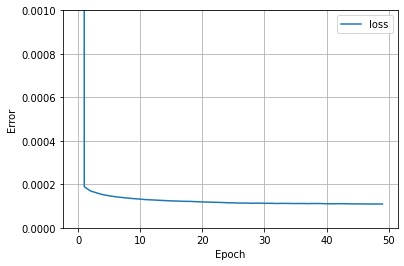

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  # plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim(0,0.001)
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  
plot_loss(history)

0

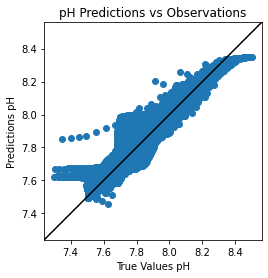

In [ ]:
test_predictions = dnn_model.predict(train_inputs).flatten()

count = 0
ind = 0
for o in test_predictions:
  if float(o) < 7.3 or float(o) > 8.5:
    count += 1
    print(ind)
  ind += 1
display(count)


ax = plt.axes(aspect='equal')

plt.scatter(train_outputs, test_predictions)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.ylim(lims)
plt.xlim(lims)
plt.plot(lims,lims, color='black')

plt.title('pH Predictions vs Observations')
plt.xlabel('True Values pH')
plt.ylabel('Predictions pH')

plt.show()

In [ ]:
dnn_model.save(model_dir+'tanh_'+model_name)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Adam Gibbs/data/models/tanh_DNN(32,16)dyear/assets
